
#### Сформируйте посредством sklearn.make_classification датасет из 100 объектов с двумя признаками.  Обучите случайный лес из 1, 3, 10 и 50 деревьев и визуализируйте их разделяющие гиперплоскости на графиках по подобию визуализации деревьев из предыдущего урока, заменив вызов функции predict на tree_vote.

#### Сделайте выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нём.



In [93]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np
import pandas as pd
from itertools import chain

In [98]:
# сгенерируем данные, представляющие собой 100 объектов с 2-мя признаками
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, random_state=147)


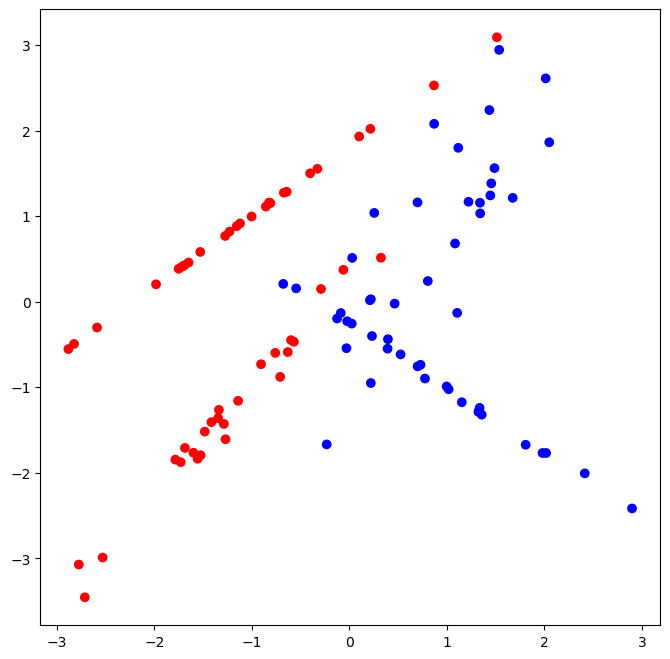

In [99]:

# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [100]:
def get_bootstrap(data, labels, N):
    
    """ функция получает на вход данные, придикт (метка класа) и количкство выборок N 
    которые мы хотим создать (количество деревьев в лесу), из этих данных формируются
    бутстрапированые выборки (из исх выборки с возвратом формируются новые выборки т.е
    берется  обьект (строка датафрейма) и он может быть взять повторно в ту же выборку, 
    размер бутстраповской выорки равен размеру исходной выборки)"""
    
    n_samples = data.shape[0] # количество строк фрейма они же точки данных (длина фрейма)
    bootstrap = [] 

    for i in range(N):
        # зададим N масивов равных исходном данным и придикту, вначале заполними N масивов 0
        b_data = np.zeros(data.shape) 
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            # в созданые масивы запишем рандомными данными из нашей выборки (придикт будет в соответсвии с данными)
            sample_index = random.randint(0, n_samples-1) # задаем рандомное число что бы потом
            #выбрать случайную строку из данных и придикта, индексация идет с 0 поэтому длина выборки уменьшается на 1
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]     
        bootstrap.append((b_data, b_labels)) # добавляем в список кортеж состоящий из данных и придикта
  

    return bootstrap

In [101]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [81]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        
        
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе 
        # он и будет нашим предсказанием для обьекта прошедшего до данного листа 
        prediction = max(classes, key=classes.get)
        return prediction        

In [102]:
# Функция выбора критерия загрязнености данных

def functional_of_quality(labels, criterion):
    
    """Считаем функцию качества (информационого прироста) далее будем ее использовать через quality
    во всех узлах для поиска разьиения или остановки дерева (когда нет прироста в качестве или же 1 обьект в листе)"""

    labels = list(labels) # отсюда можно посчитать общее количесво встречаемой метки
    set_labels = set(labels) # метки без повторов что бы не проходится несколько раз по одной и той же метке
    
    entropy = 0
    impurity = 1
    for label in set_labels: #расматриваем каждую метку по отдельности
        p = labels.count(label) / len(labels) # сумма обьектов принадлежащих к 1 метки / общее число обьектов
        entropy -= p * np.log2(p)
        impurity -= p ** 2
    if  criterion == 'gini':  
        return impurity
    elif criterion == 'entropy':  
        return  entropy
    elif criterion == 'MSE': 
        return  np.mean((labels - np.mean(labels))**2) 
    else:
        return 'Не существующий критерий'

# расчт качества текущего узла (критерий на текущем уровне дерева)
def quality(left_labels, right_labels, current_quality, criterion):
    
    """Считает текущую функцию качества джини энтропию mse в каждом узле """
    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0] / (left_labels.shape[0] + right_labels.shape[0]))
    return current_quality - p * functional_of_quality(left_labels, criterion) - (1 - p) * functional_of_quality(right_labels, criterion)



In [103]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    """ Функция получет данные, метки класа порог и индекс признака с этим порогом,
       Функция делит данные в соответсвие с данным порогом на лево и право  """
    
    # получаем индексы данных после разбиения по порогу 
    left = np.where(data[:, index] <= t) 
    right = np.where(data[:, index] > t)
        
    true_data = data[left] 
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

# Нахождение наилучшего разбиения

def find_best_split(data, labels, criterion='gini',  min_leaf=1):
   
    current_criterion = functional_of_quality(labels, criterion)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features): # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается 1
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            # расчет прироста информации 
            current_quality = quality(true_labels, false_labels, current_criterion, criterion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index



In [104]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, criterion='gini', deep_tree=5, count=0):
    
    """ Функция будет работать до тех пор пока есть прирост в качестве или не ост 1 об
    в листе( в этом случае прирота так же не возможен )"""
    
    quality, t, index = find_best_split(data, labels, criterion, min_leaf=8)
   
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
    
    # в бинарном дереве нет смысла считать листья так как количество листьев будет 2**n, где n - глубина дерева
    # соответственно мы можем ограничить глубину:
    if count >= deep_tree: # ограничения счетчика по глубине дерева
        return Leaf(data, labels)
    
        
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    
    # инкрементируем счетчик глубины дерева
    count += 1
    
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, criterion=criterion, deep_tree = deep_tree, count=count)
    false_branch = build_tree(false_data, false_labels, criterion=criterion, deep_tree = deep_tree, count=count)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [105]:
def random_forest(data, labels, n_trees):
    """ Добовляем все ранее созданые деревья в лес """
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest


In [106]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes
# предсказание голосованием деревьев

In [107]:
def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions
# Разобьем выборку на обучающую и тестовую

In [108]:
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)
# Введем функцию подсчета точности как доли правильных ответов



In [109]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
            
    return correct / float(len(actual)) * 100.0
# meshgrid

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
# Визуализируем дерево на графике

In [110]:
def plot_forest(my_forest, train_data, train_labels, train_accuracy, test_accuracy):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f} on {len(my_forest)} trees')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f} on {len(my_forest)} trees')
    
    


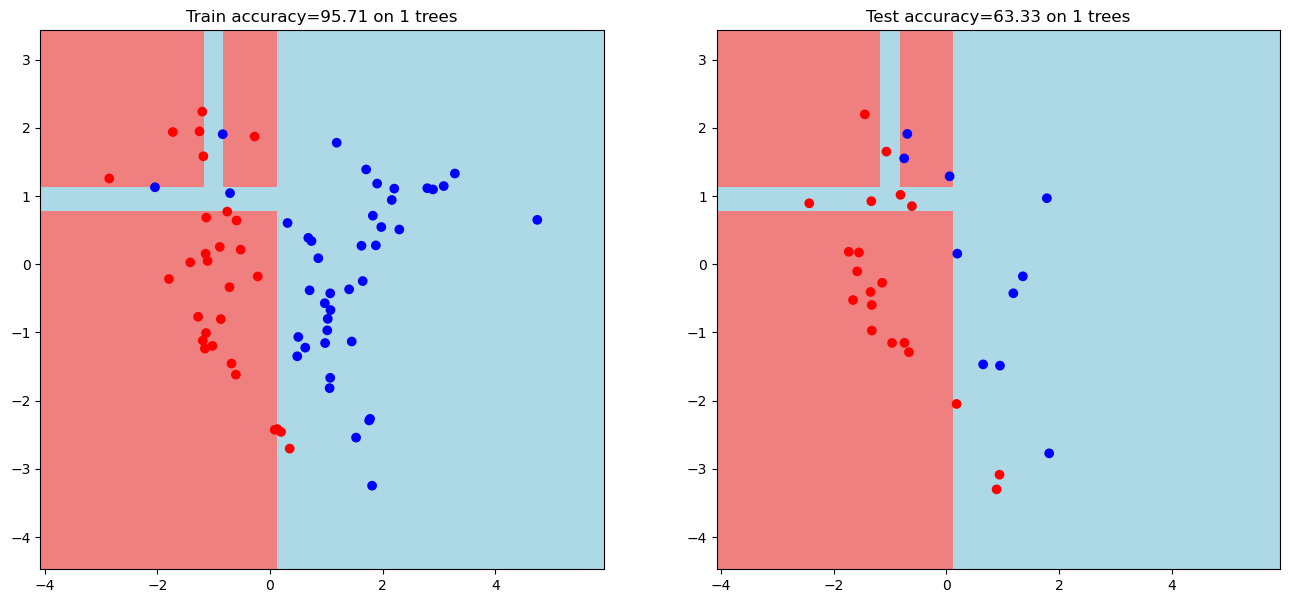

In [92]:
def metrics_random_forest(train_data, train_labels, n_trees):
    my_forest = random_forest(train_data, train_labels, n_trees)
    # Получим ответы для обучающей выборки 
    train_answers = tree_vote(my_forest, train_data)
    # И получим ответы для тестовой выборки
    test_answers = tree_vote(my_forest, test_data)
    # Точность на обучающей выборке
    train_accuracy = accuracy_metric(train_labels, train_answers)
    # Точность на тестовой выборке
    test_accuracy = accuracy_metric(test_labels, test_answers)
    plot_forest(my_forest, train_data, train_labels, train_accuracy, test_accuracy)
metrics_random_forest(train_data, train_labels, n_trees=1)

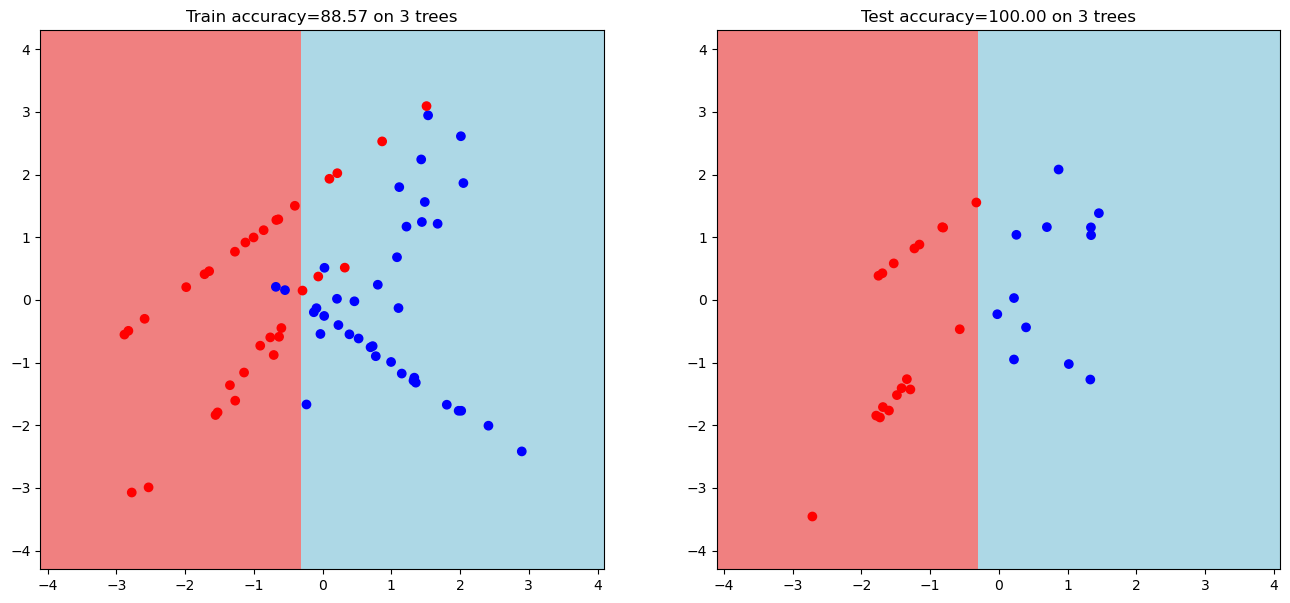

In [111]:
metrics_random_forest(train_data, train_labels, n_trees=3)

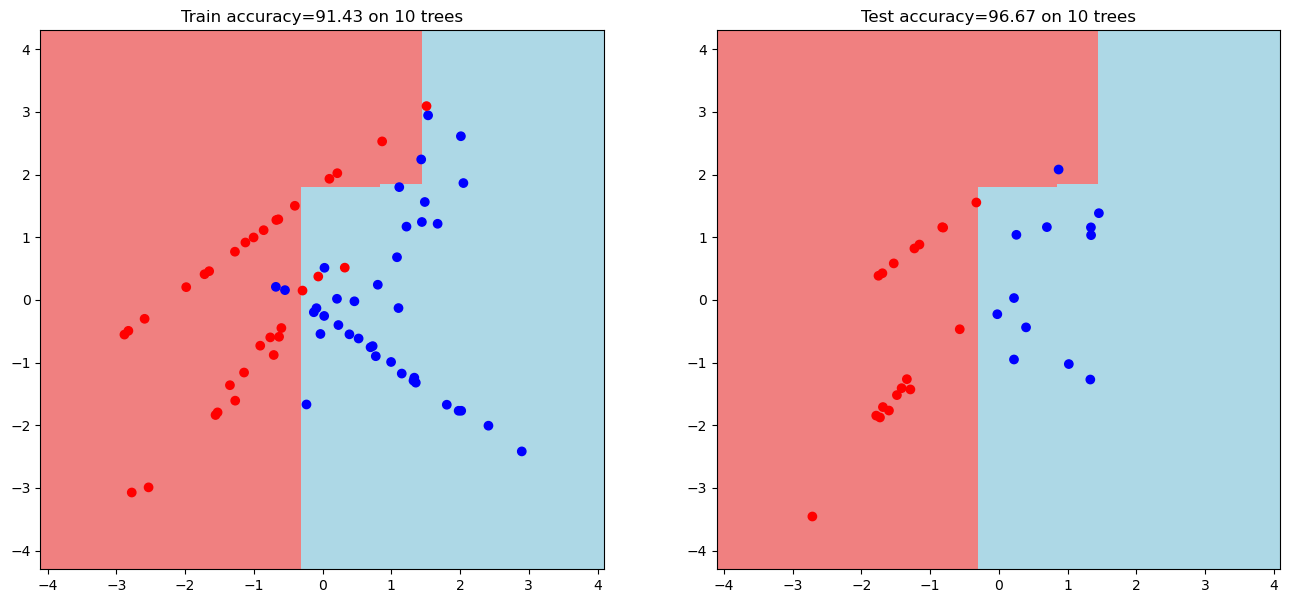

In [112]:
metrics_random_forest(train_data, train_labels, n_trees=10)

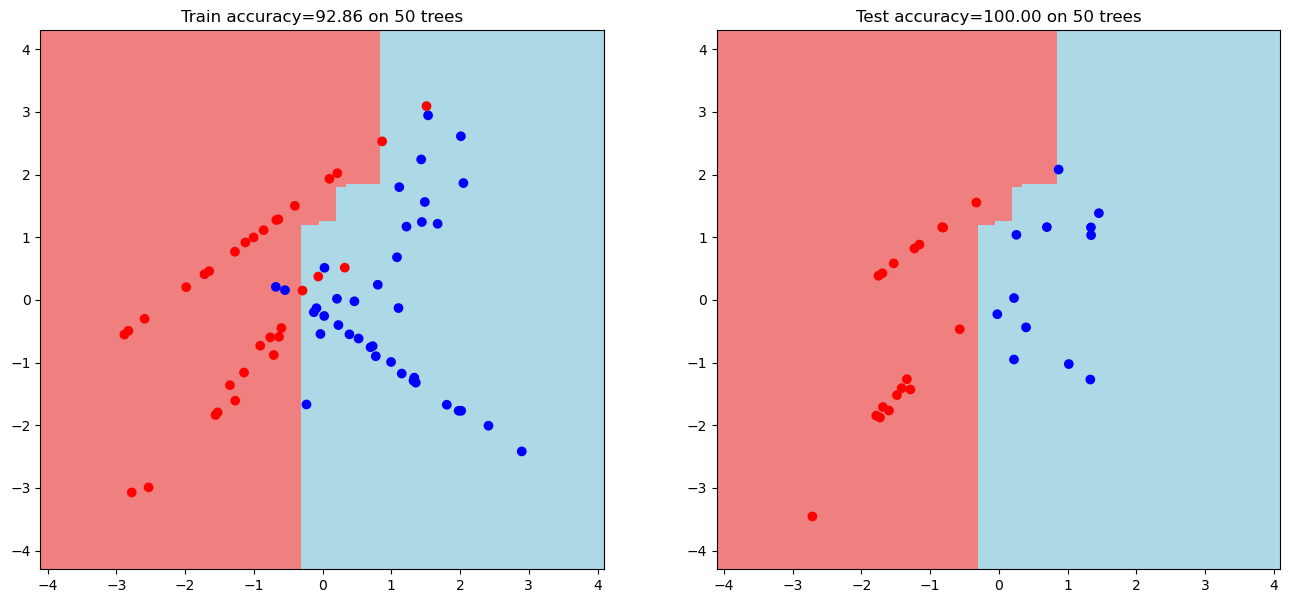

In [113]:
metrics_random_forest(train_data, train_labels, n_trees=50)

Как видно модель из 1 дереве стремится переобучится и запомнить набор обучающих данных. Модели уже из нескольких деревьев лучше обобщают данные и менее склоны к переобучению. Увеличение количества деревьев в некоторых случаях ведет к снижению переобучения но при этом качество метрик что на тесте что на трейне растет. Так же при сильном увеличении количества деревьев можнно добится обратной ситуации переобучения на тесте и недообучения на трейне

### Замените в реализованном алгоритме проверку, используя отложенную выборку на Out-of-Bag.

#### (На повторение) Перепишите функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шеннона. Переименуйте функцию в calc_entropy

In [114]:
# Тут дополнительно к бутстрап выборке определяется список объектов и соответствующих деревьях на которых эти объекты не будут обучаться

def get_bootstrap_oob(data, labels, N):
    
    n_samples = data.shape[0]
    bootstrap = []
    oob_indexes = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        idx = [i for i in range(len(data))]
        idx_history = []
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1) 
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            idx_history.append(sample_index)
        
        idx_history = np.unique(idx_history, axis = 0)
        idx[:] = [v for i,v in enumerate(idx) if i not in idx_history]
           
        bootstrap.append((b_data, b_labels))
        oob_indexes.append(idx)
        XperT = Xt(oob_indexes, n_samples)    
    
    return bootstrap, XperT
# находим списки индексов деревьев на которых не обучались объекты


In [115]:
def Xt(oob_indexes, N):
    X = []
    e = []
    for i in range(N):
        Xi = []
        for j in range(len(oob_indexes)):
            try:
                oob_indexes[j].index(i)
                Xi.append(j)
            except ValueError:
                e.append([j,i]) 
        X.append(Xi)
    return X


In [119]:
# функция формирования предсказания по одному объекту OOB на лесе, не обученному на этом объекте

def predict_oob(obj, forest, idx_oob): 
    classes = []
    sum_ = 0
    for t_id in idx_oob:
        prediction = classify_object(obj, forest[t_id])
        sum_ = sum_ + prediction
    if len(idx_oob) == 0:
        return 0
    
    return int(round(sum_/len(idx_oob)))

In [120]:
def oob_data_prepare(forest, data, list_oob_idx):
    oob_predict = []
    oob_labels = []
    
    for idx in range(len(list_oob_idx)):
        oob_predict.append(predict_oob(data[idx], forest, list_oob_idx[idx]))

    return oob_predict

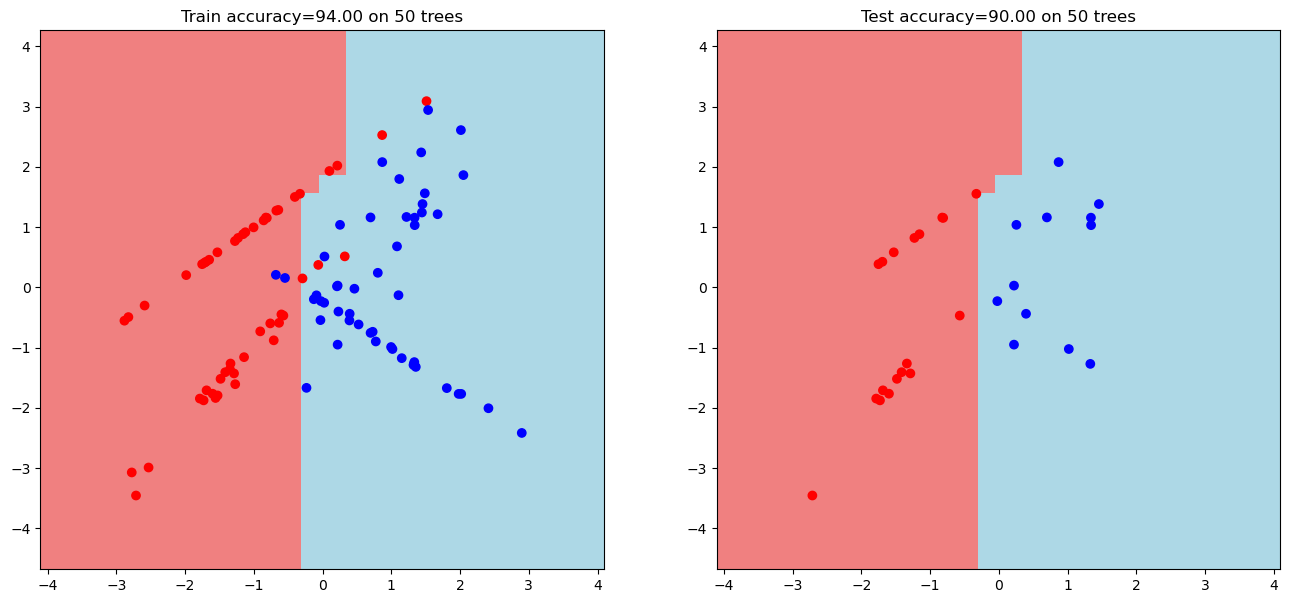

In [121]:
def random_forest_oob(data, labels, n_trees):
    forest = []
    bootstrap, idx = get_bootstrap_oob(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest, idx


def metrics_random_forest_oob(data, labels, n_trees):
    my_forest,  oob_indexes = random_forest_oob(data, labels, n_trees)
    
    # Получим ответы для обучающей выборки 
    train_answers = tree_vote(my_forest, data)
    
    
    # И получим ответы для oob выборки и соответствующую oob выборку целевых переменных
    oob_predict = oob_data_prepare(my_forest, data, oob_indexes)
    
    # Точность на обучающей выборке
    train_accuracy = accuracy_metric(labels, train_answers)
    
    # Точность на OOB выборке
    
    test_accuracy = accuracy_metric(labels, oob_predict)
    
    plot_forest(my_forest, data, labels, train_accuracy, test_accuracy)
metrics_random_forest_oob(classification_data, classification_labels, n_trees=50)

3*. (На повторение) Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy.



In [117]:
def entropy(labels):
    
    """Считаем функцию качества (информационого прироста) далее будем ее использовать через quality
    во всех узлах для поиска разьиения или остановки дерева (когда нет прироста в качестве или же 1 обьект в листе)"""

    labels = list(labels) # отсюда можно посчитать общее количесво встречаемой метки
    set_labels = set(labels) # метки без повторов что бы не проходится несколько раз по одной и той же метке
    
    entropy = 0
    for label in set_labels: #расматриваем каждую метку по отдельности
        p = labels.count(label) / len(labels) # сумма обьектов принадлежащих к 1 метки / общее число обьектов
        entropy -= p * np.log2(p)  
        return entropy
    

In [118]:
entropy(classification_labels)


0.5